In [79]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Setup

## Plotting functions

In [80]:
# Plot membrane potential 
def plot_V_m(V_neuron, spike_times, time):
  """
  Plot membrane potential of a single neuron

  Args:
  V_neuron    : Voltage of a single neuron
  spike_times : spike train

  Returns:
  Figure of the membrane potential trajetory for a single neuron
  """
  if spike_times.size:
    spike_times_int = (spike_times / dt).astype(int) - 1
    V_neuron[spike_times_int] += 20  # draw part of spike above threshold

  plt.plot(time, V_neuron, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--')
  plt.plot(spike_times,np.max(V_neuron)+0*spike_times,'ro')
  plt.xlabel('Time (ms)')
  plt.ylabel('Membrane potential (mV)')
  plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
            loc=[1.05, 0.75])
  plt.ylim([-75, 0])
  plt.show()


# Plot the raster of spike train
def plot_raster(spikes_matrix, time):
  """
  Makes raster plot with spike trains

  Args:
    time         : time of simulation [ms]
    spike_matrix : binary spike trains, with shape (N, Lt)

  Returns:
    Raster plot of the Poisson spike train
  """

  plt.figure()
  plt.plot(spikes_matrix[0],spikes_matrix[1],'k.')
  plt.ylabel('Index of spiking neuron')
  plt.xlabel('Time (ms)')
  plt.show()

## Parameters

In [82]:
# Defining parameters

# typical neuron parameters#
C_m = 200       # membrane capacitance [pF] 
g_L = 10        # leak conductance [nS]
E_L = -75       # leak reversal potential [mV] 
V_th = -50      # threshold current
V_reset = -65   # Post-spike reset potential [mV]
tau_m = 24      # membrane time constant [ms] 
V_init = -65    # initial potential [mV] 
t_ref = 2       # absolute refractory time (ms) 
V_lb = -80      # lower boundary

# typical Poisson input parameters#
tau_p = 5       # Poisson time constant [ms]
j_p = 15        # Poisson weight 
N_p= 350        # number of Poisson neurons  
ratio_p = 5/1000# noise amplitute [Hz] 

# typical excitatory and inhibitory synaptic transmission parameters
V_e = 0         # Excitatory reversal potential [mV]
V_i = -85       # Inhibitory reversal potential [mV]
N_e = 340       # nr of excitatory neurons 
N_i = 60        # nr of inhibitory neurons 
tau_e = 8       # excitatory synaptic conductance time constant [ms]
tau_i = 4       # inhibitory synaptic conductance time constant [ms] 

# Connection probabilities
pee = 0.01      # connection probability of exc to exc cell 
pei = 0.15      # connection probability of inh to exc cell 
pie = 0.15      # connection probability of exc to inh cell 
pii = 0.1       # connection probability of inh to inh cell 
pex = 0.1       # connection probability of Poisson to exc cell
pix = 0.1       # connection probability of Poisson to inh cell

# Synaptic weights
jee = 350       # synaptic weight from exc to exc cell 
jei = -2100     # synaptic weight from inh to exc cell
jie = 2000      # synaptic weight from exc to inh cell 
jii = -3500     # synaptic weight from inh to inh cell
jex = 2250      # synaptic weight from Poisson to exc cell 
jix = 2000      # synaptic weight from Poisson to inh cell 

# Conductances
gE_bar = 2.4    # excitatory conductance [nS] 
gI_bar = 2.4    # inhibitory conductance [nS]

# Simulation parameters 
T = 100      # Total duration of simulation [ms]
dt = .1         # Simulation time step [ms]

# Time vector
time = np.arange(0, T, dt)  # Vector of discretized time points [ms]


# Poisson process
`poisson_spikes_matrix ` is a family of $N_p$ Poisson processes modeling the spike times of $N_p$ neurons. It is stored as a matrix with two rows. The first row, `poisson_spikes_matrix[0,:]`, is a vector of spike times (random numbers in $[0,T]$) and `poisson_spikes_matrix[1,:]` is a vector of associated neuron indices (integers from  $0$ to  $N_p-1$). 

In [ ]:
# Generate Poisson spike trains

def generate_poisson_spikes(N_p, rate_p, j_p, tau_p, myseed = False):
  """
  Generates poisson spike trains

  Args:
    pars                      : parameter dictionary
    myseed                    : random seed. int or boolean
    N_p                       : number of Poisson neurons
    ratio_p                   : noise amplitute [Hz] 
    j_p                       : Poisson synaptic weight
    tau_p                     : Poisson synaptic constant

  Returns:
    poisson_spikes_matrix      : matrix with two rows - poisson_spikes_matrix[0,:] -
                                a vector of spike times and poisson_spikes_matrix[1,:] 
                                is a vector of associated neuron indices
    I_p                        : Input current [pA] (here: generated by Poisson distribution)
    I_p_bar                    : Theoretical input current [pA]
    poisson_spikes_int         : Total number of Poisson spikes
  """
 
  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # The total number of spikes obeys a Poisson
  # distribution with expectation rx*Nx*T
  poisson_spikes_int =np.random.poisson(ratio_p*N_p*T)
  poisson_spikes_matrix=np.zeros((2,poisson_spikes_int))

  # Spike times and indices are uniformly distributed
  # once we condition on the total number of spikes
  poisson_spikes_matrix[0,:]=np.random.rand(poisson_spikes_int)*T
  poisson_spikes_matrix[1,:]=np.random.randint(0,N_p,size=poisson_spikes_int)

  # Sort spike times 
  sort=np.argsort(poisson_spikes_matrix[0,:])
  poisson_spikes_matrix=poisson_spikes_matrix[:,sort]

  # Initialize Input current
  I_p=np.zeros_like(time)

  # Implement the ODE version of the Ix model
  i_p=0
  for i in range(1,len(time)):
    I_p[i]=I_p[i-1]-dt*I_p[i-1]/tau_p
    while (i_p<poisson_spikes_int and poisson_spikes_matrix[0,i_p]<=i*dt):
      I_p[i]+=j_p/tau_p
      i_p+=1

  # Calculate theoretical stationary mean value
  # of Ix, i.e., E[Ix]
  I_p_bar=N_p*j_p*ratio_p

  print('Theoretical mean of Poisson input current:',I_p_bar)
  print('Empirical mean of Poisson input current:',np.mean(I_p))

  return poisson_spikes_matrix, I_p, I_p_bar, poisson_spikes_int


# run Single neuron model
def run_EIF_ext(I_inj):
  """
  Simulate a single neuron modeled as Exponential Integrate and Fire (EIF) neuron dynamics with external input current

  Args:
    I_inj            : input current [pA] (here: injected current)(value or an array)

  Returns:
    spike_times      : spike times [ms] (array)
    V_neuron         : mebrane potential [mV] (array)
  """
  # Initialize membrane potential and external current
  V_neuron = np.zeros(len(time))
  V_neuron[0]=V_init
  I_inj = I_inj * np.ones(len(time))

  # Initialize postsynaptic spike train
  spike_times = np.zeros(len(time)) # record spike times
  spike_int = 0
  # tr = 0. 
  
  # Simulate EIF dynamics
  for i in range(1,len(time)):
    # Update the membane potential
    V_neuron[i] = V_neuron[i-1]+dt*(I_inj[i-1]/g_L+(E_L-V_neuron[i-1])+t_ref*np.exp((V_neuron[i-1]-V_th)/t_ref))/tau_m
    V_neuron[i] = np.maximum(V_neuron[i],V_lb)

    # if there is a spike
    if (V_neuron[i] >= V_th):    
      V_neuron[i] = V_reset
      V_neuron[i-1] = V_th # This just makes plots look nicer
      spike_times[spike_int]=i*dt
      spike_int += 1

  # Compute rate
  print("Number of spikes:", spike_int)
  rate=(spike_int)/T
  print('Postsynaptic rate =',1000*rate,'Hz')

  return V_neuron, spike_times

# Simulate neuron with external (i.e.,"injected") current


# Modeling a postsynaptic neuron

Now model the membrane potential of a postsynaptic neuron using the exponential integrate-and-fire (EIF) model, which obeys the ODE
$$
\tau_m \frac{dV}{dt}=-(V-E_L)+D_T e^{(V-V_T)/D_T}+I_x
$$
with the added condition
$$
V(t)\ge V_{th}\Rightarrow V(t)\gets V_{re},\textrm{ record a spike}
$$

Number of spikes: 3
Postsynaptic rate = 30.0 Hz


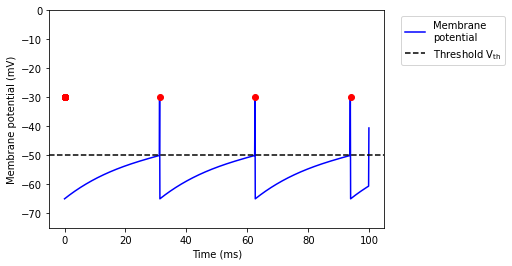

In [83]:
V_neuron, spike_times = run_EIF_ext(I_inj = 300)
plot_V_m(V_neuron, spike_times, time)

# Simulate neuron with Poisson input current

Theoretical mean of Poisson input current: 26.25
Empirical mean of Poisson input current: 21.94220573601674


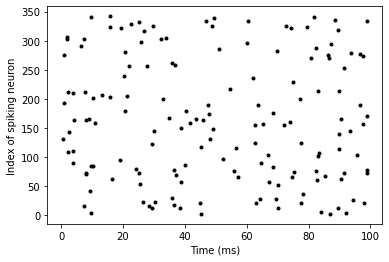

In [84]:
# Simulate Poisson spikes
poisson_spikes_matrix, I_p, I_p_bar, poisson_spikes_int = generate_poisson_spikes(N_p, ratio_p, j_p, tau_p, myseed = 2022)
# Plot Poisson spikes
plot_raster(poisson_spikes_matrix, time)
# Simulate single neuron 